In [1]:
# This notebook calcualtes summary tables for a range of heat, drought, rainfall and runoff hazard metrics
# each metric need slightly different code to calculate the min median and max values of the regional averages for the ensemble of models
# due to different collection of models and different fiel naming conventions.

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions

import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

In [4]:
# mask
# this shows fractional mask
mask_ncra = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_ncra-regions.nc")['mask']
mask_aust = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_australia.nc")['mask']

mask = xr.concat([mask_ncra, mask_aust], dim="region")
mask = mask.assign_coords({"region":np.arange(0,len(mask["region"]))})


directory = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i"
agcd = xr.open_dataset(f"{directory}/mask-fraction_agcd_v1-0-2_precip_weight_1960_2022.nc").fraction

In [5]:
_list = [('BOM', 'ACCESS-CM2', 'BARPA-R', 'r4i1p1f1'),
         ('BOM', 'ACCESS-ESM1-5', 'BARPA-R', 'r6i1p1f1'),
         ('BOM', 'CESM2', 'BARPA-R', 'r11i1p1f1'),
         ('BOM', 'CMCC-ESM2', 'BARPA-R', 'r1i1p1f1'),
         ('BOM', 'EC-Earth3', 'BARPA-R', 'r1i1p1f1'),
         ('BOM', 'MPI-ESM1-2-HR', 'BARPA-R', 'r1i1p1f1'),
         ('BOM', 'NorESM2-MM', 'BARPA-R', 'r1i1p1f1'),
         ('CSIRO', 'ACCESS-CM2', 'CCAM-v2203-SN', 'r4i1p1f1'),
         ('CSIRO', 'ACCESS-ESM1-5', 'CCAM-v2203-SN', 'r6i1p1f1'),
         ('CSIRO', 'CESM2', 'CCAM-v2203-SN', 'r11i1p1f1'),
         ('CSIRO', 'CMCC-ESM2', 'CCAM-v2203-SN', 'r1i1p1f1'),
         ('CSIRO', 'CNRM-ESM2-1', 'CCAM-v2203-SN', 'r1i1p1f2'),
         ('CSIRO', 'EC-Earth3', 'CCAM-v2203-SN', 'r1i1p1f1')]

model_list = [f"{parent}_{downscaling}_{member}" for institution_id, parent, downscaling, member in _list]

In [6]:
def ensemble_summary(filelist_gwls,
                     var,
                     stats_var=None,
                     mask=mask,
                     preprocess=None, 
                     gwls=["GWL12", "GWL15", "GWL20", "GWL30"], 
                     rounding=1):
    """Calculate the ensemble min, median, max for each GWL"""
    if stats_var is None:
        stats_var=var
    
    gwl_list =[]
    
    for gwl in gwls:
      
        ds_gwl = xr.open_mfdataset(filelist_gwls[gwl], 
                                   preprocess= lambda ds: preprocess(ds, var, gwl),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append(ds_gwl)
    
    ds = xr.merge(gwl_list)
    
    # calculate the region average
    da_summary = acs_regional_stats(ds=ds, var=stats_var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{stats_var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{stats_var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{stats_var}_mean":"max"}),])
    
    ds_min_max = ds_min_max.round(rounding)
    if rounding==0:
        ds_min_max = ds_min_max.astype("int")
    
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-average.csv")
    return df

In [7]:
def ensemble_summary_change(filelist_gwls,
                             var,
                             stats_var=None,
                             mask=mask,
                             preprocess=None, 
                             gwls=["GWL12", "GWL15", "GWL20", "GWL30"], 
                             rounding=1):
    """Calculate the total change from GWL12.
    Model-wise differences are calculated first, then regional averages are calculated. 
    Summary statistics - min/median/max - are calculated for each region. 
    Finally, the values are rounded to "rounding" number of decimal places."""
    if stats_var is None:
        stats_var=var
    
    gwl=gwls[0]
    ds_gwl12 = xr.open_mfdataset(filelist_gwls[gwl], 
                                   preprocess= lambda ds:preprocess(ds, var, gwl),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
    
    gwl_list =[]
    
    for gwl in gwls[1:]:
      
        ds_gwl = xr.open_mfdataset(filelist_gwls[gwl], 
                                   preprocess= lambda ds: preprocess(ds, var, gwl),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append((ds_gwl.sel(gwl=gwl)-ds_gwl12.sel(gwl=gwls[0])).expand_dims({"gwl":[f"{gwl}-{gwls[0]}"]}))
    
    ds = xr.merge(gwl_list)
    
    # calculate the region average
    da_summary = acs_regional_stats(ds=ds, var=stats_var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{stats_var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{stats_var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{stats_var}_mean":"max"}),])
    
    ds_min_max = ds_min_max.round(rounding)
    if rounding==0:
        ds_min_max = ds_min_max.astype("int")
    
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-change.csv")
    return df

In [8]:
def ensemble_summary_change_perc(filelist_gwls,
                                 var,
                                 stats_var=None,
                                 mask=mask,
                                 preprocess=None, 
                                 gwls=["GWL12", "GWL15", "GWL20", "GWL30"], 
                                 rounding=1):
    """Calculate the percent change from GWL12"""
    if stats_var is None:
        stats_var=var
    
    gwl=gwls[0]
    ds_gwl12 = xr.open_mfdataset(filelist_gwls[gwl], 
                                   preprocess= lambda ds:preprocess(ds, var, gwl),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
    
    gwl_list =[]
    
    for gwl in gwls[1:]:
      
        ds_gwl = xr.open_mfdataset(filelist_gwls[gwl], 
                                   preprocess= lambda ds: preprocess(ds, var, gwl),
                                   use_cftime=True,
                                   combine="nested",
                                   concat_dim="model",
                                   combine_attrs= "drop_conflicts").load()
        gwl_list.append((100*(ds_gwl.sel(gwl=gwl)-ds_gwl12.sel(gwl=gwls[0]))/ds_gwl12.sel(gwl=gwls[0])).expand_dims({"gwl":[f"{gwl}-{gwls[0]}"]}))
    
    ds = xr.merge(gwl_list)
    
    # calculate the region average
    da_summary = acs_regional_stats(ds=ds, var=stats_var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
    
    #find the min, median and max of ensemble members
    ds_min_max = xr.merge([da_summary.min(dim=["model"]).rename({f"{stats_var}_mean":"min"}),
                            da_summary.median(dim=["model"]).rename({f"{stats_var}_mean":"median"}),
                            da_summary.max(dim=["model"]).rename({f"{stats_var}_mean":"max"}),])
    
    ds_min_max = ds_min_max.round(rounding)
    if rounding==0:
        ds_min_max = ds_min_max.astype("int")
    
    df = ds_min_max.to_dataframe().reset_index()[["gwl", "abbrevs", "names", "min", "median","max"]]
    df.to_csv(f"tables/{var}_ncra-regions_gwl-change.csv")
    return df

# Heat

In [9]:
# heat hazards
rounding_dict = {"TXx":1, "TXm":1, "TGm":1, "TXge35":0, "TXge40":0, "TXge45":0, "TNle02":0, "HW_sev_ext":0, "HWAtx":1}
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]

def _preprocess(ds, var, gwl):
    return ds.expand_dims({"gwl":[f"{gwl}"]})

for var in ["TXx", "TXm", "TGm", "TXge35", "TXge40", "TXge45", "TNle02", "HW_sev_ext", "HWAtx"]:
    path = f"/g/data/ia39/ncra/heat/data/{var}/bias-corrected/individual_models/GWL-average"

    filelist_gwls={}
    for gwl in gwls:
        filelist_gwls[gwl] = [f"{path}/{var}_AGCD-05i_{parent}_ssp370_{member}_{institution}_{downscaling_model}_v1-r1-ACS-QME-AGCD-1960-2022_{gwl}-avg.nc"
                    for institution, parent, downscaling_model, member in _list]

    ensemble_summary(filelist_gwls,
                     var,
                     stats_var=None,
                     mask=mask,
                     preprocess=_preprocess, 
                     gwls=gwls, 
                     rounding=rounding_dict[var])
        
    ensemble_summary_change(filelist_gwls,
                            var,
                            stats_var=None,
                            mask=mask,
                            preprocess=_preprocess, 
                            gwls=gwls, 
                            rounding=rounding_dict[var])

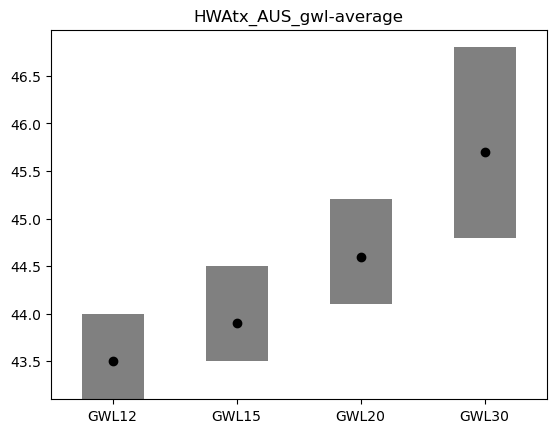

In [10]:
# make a plot from the csv
abbrev="AUS"

filename = f"{var}_ncra-regions_gwl-average"

df = pd.read_csv(f"tables/{filename}.csv", index_col="gwl", usecols=["gwl", "abbrevs", "names", "min", "median", "max"])
df = df[df.abbrevs=="AUS"]

gwls = ["GWL12", "GWL15", "GWL20", "GWL30"]
for i, gwl in enumerate(gwls):

    ens_min, ens_median, ens_max = df.loc[[gwl]][["min", "median", "max"]].values[0]
    plt.bar(x=i+1, height=ens_max - ens_min, width=0.5, bottom =  ens_min, color="grey", label=gwl)
    plt.scatter(x=i+1, y=ens_median, c="k")


plt.xlim(0.5, len(gwls)+0.5 )
plt.xticks(np.arange(1,len(gwls)+1), labels=gwls)
plt.title(f"{var}_{abbrev}_gwl-average")

plt.savefig(f"figures/{var}_{abbrev}_gwl-average.png")

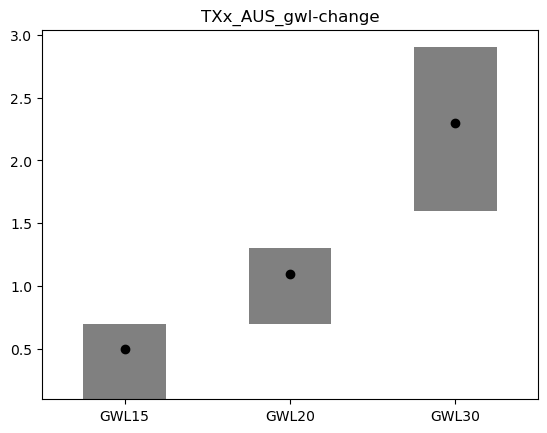

In [11]:
# make a plot from the csv
var="TXx"
abbrev="AUS"
filename = f"{var}_ncra-regions_gwl-change"
df = pd.read_csv(f"tables/{filename}.csv", index_col="gwl", usecols=["gwl", "abbrevs", "names", "min", "median", "max"])
df = df[df.abbrevs==abbrev]
gwls = ["GWL15", "GWL20", "GWL30"]


for i, gwl in enumerate(gwls):
    ens_min, ens_median, ens_max = df.loc[[f"{gwl}-GWL12"]][["min", "median", "max"]].values[0]
    plt.bar(x=i+1, height=ens_max - ens_min, width=0.5, bottom =  ens_min, color="grey", label=gwl)
    plt.scatter(x=i+1, y=ens_median, c="k")


plt.xlim(0.5, len(gwls)+0.5 )
plt.xticks(np.arange(1,len(gwls)+1), labels=gwls)
plt.title(f"{var}_{abbrev}_gwl-change")

plt.savefig(f"figures/{var}_{abbrev}_gwl-change.png")

# Extratropical storms

In [12]:
#XTS
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
rounding = 1
lat_limit = -28

var = "low_freq"
path = f"/g/data/ia39/ncra/extratropical_storms/5km/GWLs"

def _preprocess(ds, var, gwl):
    return ds.where(ds.lat<=lat_limit).expand_dims({"gwl":[f"{gwl}"]})

filelist_gwls={}
for gwl in gwls:
    filelist_gwls[gwl] = [f"{path}/lows_AGCD-05i_{parent}_ssp370_{member}_{institution}_{downscaling_model}_v1-r1_{gwl}.nc"
                          for institution, parent, downscaling_model, member in _list]

# average values
ensemble_summary(filelist_gwls,
                 var,
                 mask=mask,
                 preprocess=_preprocess, 
                 gwls=gwls, 
                 rounding=rounding)

# change 
ensemble_summary_change_perc(filelist_gwls,
                             var,
                             mask=mask,
                             preprocess=_preprocess, 
                             gwls=gwls, 
                             rounding=rounding);


In [13]:
# extreme rainfall
gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
rounding = 1

def _preprocess(ds, var, gwl):
    return ds.where(agcd>=0.8).expand_dims({"gwl":[f"{gwl}"]})

for i, var in enumerate(["RX1D", "RX5D", "RX1H"]):
    path = "/g/data/ia39/ncra/extratropical_storms/bias-corrected/ACS-QME-AGCD-1960-2022/GWLs"
    stats_var = ["prAdjust", "prAdjust", "prhmax"][i]

    filelist_gwls={}
    for gwl in gwls:
        filelist_gwls[gwl] = [f"{path}/{var}_AGCD-05i_{parent}_ssp370_{member}_{institution}_{downscaling_model}_v1-r1-ACS-QME-AGCD-1960-2022_{gwl}.nc"
                    for institution, parent, downscaling_model, member in _list]
        
    ensemble_summary_change_perc(filelist_gwls,
                                 var,
                                 stats_var=stats_var,
                                 mask=mask,
                                 preprocess=_preprocess, 
                                 gwls=gwls, 
                                 rounding=rounding)

    ensemble_summary(filelist_gwls,
                     var,
                     stats_var=stats_var,
                     mask=mask,
                     preprocess=_preprocess, 
                     gwls=gwls, 
                     rounding=rounding)

# Runoff

In [14]:
# extreme runoff 
gwls=["1.2", "1.5", "2", "3"]
rounding = 1

var = "max1day_runoff"
path = "/g/data/ia39/ncra/flood/Runoff_Max1D/runoff_max1day_ens/"
stats_var = "qtot"

def _preprocess(ds, var, gwl,):
    return ds.rename({"latitude":"lat", "longitude": "lon"}).where(agcd>=0.8).expand_dims({"gwl":[f"{gwl}"]})
    
filelist_gwls={}
for gwl in gwls:
    filelist_gwls[gwl] = glob(f"{path}/max1day_runoff_ens_rcp85_*_*_{gwl}.nc")
    
ensemble_summary_change_perc(filelist_gwls,
                             var,
                             stats_var="qtot",
                             mask=mask,
                             preprocess=_preprocess, 
                             gwls=gwls, 
                             rounding=rounding)

ensemble_summary(filelist_gwls,
                 var,
                 stats_var="qtot",
                 mask=mask,
                 preprocess=_preprocess, 
                 gwls=gwls, 
                 rounding=rounding);


In [15]:
# extreme runoff 
#R90PERC
# runoff_annual_total_90perc

gwls=["1.2", "1.5", "2", "3"]
rounding = 1

var = "runoff_annual_total_90perc"
path = "/g/data/ia39/ncra/flood/Runoff_annual_total_90perc/runoff_annual_total_90perc_gwl/"
stats_var = "qtot"

def _preprocess(ds, var, gwl,):
    return ds.rename({"latitude":"lat", "longitude": "lon"}).where(agcd>=0.8).expand_dims({"gwl":[f"{gwl}"]})
    

filelist_gwls={}
for gwl in gwls:
    filelist_gwls[gwl] = glob(f"{path}/proj_runoff_annual_90_perc_rcp85_*_{gwl}.nc")
    
ensemble_summary_change_perc(filelist_gwls,
                             var,
                             stats_var="qtot",
                             mask=mask,
                             preprocess=_preprocess, 
                             gwls=gwls, 
                             rounding=rounding)

ensemble_summary(filelist_gwls,
                 var,
                 stats_var="qtot",
                 mask=mask,
                 preprocess=_preprocess, 
                 gwls=gwls, 
                 rounding=rounding);

# Drought Aridity

In [16]:
# drought
gwls=["GWL1.2", "GWL1.5", "GWL2.0", "GWL3.0"]
var = "SPI3"
rounding=1

filelist_gwls={}
path = f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME"
for gwl in gwls:
    filelist_gwls[gwl] = [f"{path}/SPI3_pct_time_below_-1_AGCD-05i_{parent}_ssp370_{member}_{institution}\
_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_{gwl}.nc"
                for institution, parent, downscaling_model, member in _list]
    

def _preprocess(ds, var, gwl):
    return ds.where(agcd>=0.8).expand_dims({"gwl":[f"{gwl}"]})

ensemble_summary(filelist_gwls,
                 var,
                 mask=mask,
                 preprocess=_preprocess, 
                 gwls=gwls, 
                 rounding=rounding)

ensemble_summary_change_perc(filelist_gwls,
                                 var,
                                 mask=mask,
                                 preprocess=_preprocess, 
                                 gwls=gwls, 
                                 rounding=rounding);

In [17]:
# drought

gwls=["GWL12", "GWL15", "GWL20", "GWL30"]
rounding = 1
var = "AI"
path = f"/g/data/ia39/ncra/drought_aridity/ai/nhp1_BC_5km/GWL"

filelist_gwls={}
for gwl in gwls:
    filelist_gwls[gwl] =  glob(f"{path}/{var}-atmospheric-based_NHP1-AUS-5_*_rcp85_r*_*2D_{gwl}.nc")

def _preprocess(ds, var, gwl):
    return ds.where(agcd>=0.8).expand_dims({"gwl":[f"{gwl}"]})

ensemble_summary(filelist_gwls,
                 var,
                 mask=mask,
                 preprocess=_preprocess, 
                 gwls=gwls, 
                 rounding=2)

ensemble_summary_change_perc(filelist_gwls,
                                 var,
                                 mask=mask,
                                 preprocess=_preprocess, 
                                 gwls=gwls, 
                                 rounding=rounding);

In [18]:
# drought
gwls=["GWL1.2", "GWL1.5", "GWL2.0", "GWL3.0"]
rounding = 1

var = "p15_3month"
path = f"/g/data/ia39/ncra/drought_aridity/rainfall_percentiles/downscaled_BC_5km/GWLs"

filelist_gwls={}
for gwl in gwls:
    filelist_gwls[gwl] = glob(f"{path}/{var}_AGCD-05i_*_{gwl}_ACS-QME-AGCD-1960-2022.nc")

def _preprocess(ds, var, gwl):
    return ds.where(agcd>=0.8).mean(["month"]).expand_dims({"gwl":[f"{gwl}"]})

ensemble_summary(filelist_gwls,
                 var,
                 mask=mask,
                 preprocess=_preprocess, 
                 gwls=gwls, 
                 rounding=rounding)

ensemble_summary_change_perc(filelist_gwls,
                                 var,
                                 mask=mask,
                                 preprocess=_preprocess, 
                                 gwls=gwls, 
                                 rounding=rounding);

# Available heatmaps
- heat: TXx, 
- drought/aridity: SPI3<-1 (https://github.com/AusClimateService/hazards-drought/blob/main/spi/plot_spi.ipynb)
- flood: code not available, but heatmap pngs and csvs are g/data/ia39/ncra/flood/Runoff_Max1D/statistics_heat_maps/heatmap_runoff_percentage_change_GWL_2.png



